In [283]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import os
from datetime import datetime,timedelta

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import statsmodels.api as sm
from pylab import rcParams
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
from dython import nominal
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from numpy import sqrt

### Data Wrangling

In [284]:
engagement_info = pd.read_csv('takehome_user_engagement.csv')
engagement_info

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [285]:
engagement_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [286]:
len(engagement_info.user_id.unique())

8823

In [287]:
engagement_info['time_stamp'] =  pd.to_datetime(
   engagement_info['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [289]:
#find out the engagement start and end time
engagement_info['time_stamp'].min(), engagement_info['time_stamp'].max()

(Timestamp('2012-05-31 08:20:06'), Timestamp('2014-06-06 14:58:50'))

In [290]:
def adopted_measure(df):
#periods =2 indicates that there are 2 periods to shift for calculating difference, so there are three days involved   
    condition1 = df['time_stamp'].diff(periods=2)
    condition2 = df['time_stamp'].diff()

    # check if any passed time is less than 7 days and they are separete days
    return any((condition1 <= timedelta(days=7)) & (condition2>timedelta(days=1)))


In [291]:
adopted_id = engagement_info.groupby('user_id').apply(adopted_measure).rename_axis().to_frame('adopted')
adopted_id.head(15)

,adopted
user_id,
1,False
2,True
3,False
4,False
5,False
6,False
7,False
10,True
11,False


In [292]:
takehome_users = pd.read_csv('takehome_users.csv', encoding='latin-1')
takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [293]:
takehome_users_engagement = pd.merge(takehome_users, adopted_id, left_on='object_id', right_on='user_id', how ='left')
takehome_users_engagement


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,False
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,False
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,False
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,False


In [294]:
takehome_users_engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     8823 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 1.1+ MB


In [295]:
#calculate the missing data
missing = pd.concat([takehome_users_engagement.isnull().sum(), 100*takehome_users_engagement.isnull().mean()], axis=1)
missing.columns = ['count', '%']
missing.sort_values(by='count')

,count,%
object_id,0,0.000
creation_time,0,0.000
name,0,0.000
email,0,0.000
creation_source,0,0.000
opted_in_to_mailing_list,0,0.000
enabled_for_marketing_drip,0,0.000
org_id,0,0.000
last_session_creation_time,3177,26.475
adopted,3177,26.475


In [296]:
#turn the labels into integers
takehome_users_engagement['adopted'] = takehome_users_engagement['adopted'].map({True:1, False:0,})


In [297]:
takehome_users_engagement['adopted'].fillna(2, inplace=True)
                          

In [298]:
takehome_users_engagement['adopted'].value_counts()

0.0    7229
2.0    3177
1.0    1594
Name: adopted, dtype: int64

In [299]:
#check duplicates
duplicate = takehome_users_engagement[takehome_users_engagement.duplicated(keep=False)]
duplicate.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted


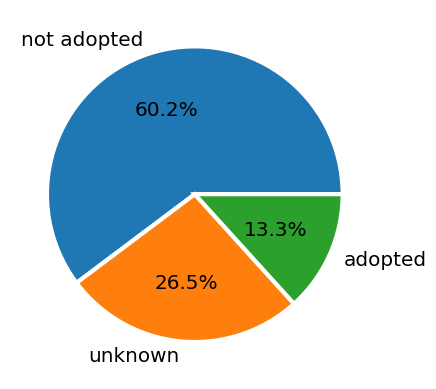

In [301]:
#'unknown'label comprises of 26% of the data,so we keep the data
adopt_percent = takehome_users_engagement.adopted.value_counts(normalize = True).transpose()
mylabels = ['not adopted', 'unknown', 'adopted']

plt.pie(adopt_percent, labels = mylabels, autopct='%.1f%%',  wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})
plt.show()


In [302]:
#generate new time features
takehome_users_engagement['creation_time'] = pd.to_datetime(
   takehome_users_engagement['creation_time'], format='%Y-%m-%d %H:%M:%S')


takehome_users_engagement['creation_day']=takehome_users_engagement['creation_time'].dt.strftime('%a')
takehome_users_engagement['creation_hour']=takehome_users_engagement['creation_time'].dt.hour
takehome_users_engagement['creation_year']=takehome_users_engagement['creation_time'].dt.year
takehome_users_engagement['creation_month']=takehome_users_engagement['creation_time'].dt.month


In [303]:

takehome_users_engagement['last_session_creation_time'] = takehome_users_engagement['last_session_creation_time'].apply(pd.to_datetime, errors='coerce', unit='s')



In [304]:
takehome_users_engagement['last_day']=takehome_users_engagement['last_session_creation_time'].dt.strftime('%a')
takehome_users_engagement['last_hour']=takehome_users_engagement['last_session_creation_time'].dt.hour
takehome_users_engagement['last_year']=takehome_users_engagement['last_session_creation_time'].dt.year
takehome_users_engagement['last_month']=takehome_users_engagement['last_session_creation_time'].dt.month


In [305]:
engagement_info['time_stamp'].max()

Timestamp('2014-06-06 14:58:50')

In [309]:
#new feature'account_age' is calculated by subtracting the creation time from max last seen datestamp
takehome_users_engagement['account_age'] = engagement_info['time_stamp'].max() - takehome_users_engagement['creation_time'] 

takehome_users_engagement['account_age'].sort_values()

6052      6 days 14:59:31
3489      6 days 15:13:49
10163     6 days 15:31:20
9687      6 days 15:46:49
6944      6 days 15:48:15
               ...       
11998   736 days 03:02:51
10011   736 days 06:38:44
7169    736 days 08:34:59
11429   736 days 13:16:19
3860    736 days 14:15:23
Name: account_age, Length: 12000, dtype: timedelta64[ns]

In order to meet the 'adoption' requirment that the user has logged into the product on three separate days in at least one sevenday, the user's account age has to be at least 5 days.

### EDA

#### creation_year vs adoption_rate

In [336]:
takehome_users_engagement.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_day,creation_hour,creation_year,creation_month,last_day,last_hour,last_year,last_month,account_age_group
0,GUEST_INVITE,1,0,11,10803.0,0.0,Tue,3,2014,4,Tue,3.0,2014.0,4.0,within 3 month
1,ORG_INVITE,0,0,1,316.0,1.0,Fri,3,2013,11,Mon,3.0,2014.0,3.0,6month-1 year
2,ORG_INVITE,0,0,94,1525.0,0.0,Tue,23,2013,3,Tue,23.0,2013.0,3.0,1-1.5 year
3,GUEST_INVITE,0,0,1,5151.0,0.0,Tue,8,2013,5,Wed,8.0,2013.0,5.0,1-1.5 year
4,GUEST_INVITE,0,0,193,5240.0,0.0,Thu,10,2013,1,Tue,10.0,2013.0,1.0,1-1.5 year


In [356]:
creation_year_adopted = pd.crosstab(takehome_users_engagement.adopted, takehome_users_engagement.creation_year).apply(lambda row: row/row.sum(), axis=0)
creation_year_adopted

creation_year,2012,2013,2014
adopted,,,
0.0,0.563818,0.58351,0.663453
1.0,0.161959,0.15081,0.080805
2.0,0.274222,0.26568,0.255741


In [357]:
creation_year_adopted_perc = creation_year_adopted.loc[1].to_frame('percent')
creation_year_adopted_perc

,percent
creation_year,
2012,0.161959
2013,0.150810
2014,0.080805


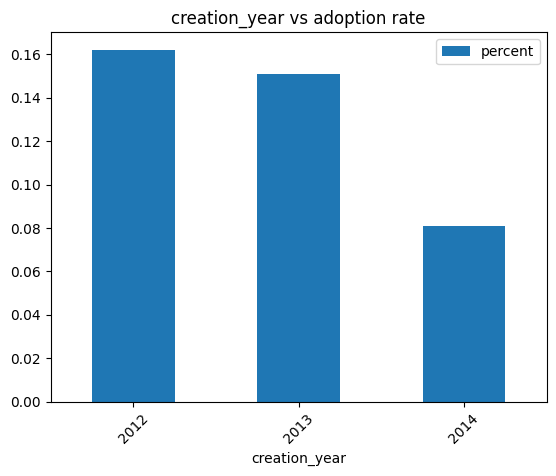

In [370]:
creation_year_adopted_perc.plot(kind='bar')
plt.title('creation_year vs adoption rate')
plt.xticks(rotation=45)
plt.show()

#### last_year vs adoption_rate

In [386]:
last_year_adopted = pd.crosstab(takehome_users_engagement.adopted, takehome_users_engagement.last_year).apply(lambda row: row/row.sum(), axis=1)
last_year_adopted


last_year,2012.0,2013.0,2014.0
adopted,,,
0.0,0.212478,0.455803,0.331719
1.0,0.029486,0.133626,0.836888


In [387]:
last_year_adopted_perc = last_year_adopted.loc[1].to_frame('percent')
last_year_adopted_perc

,percent
last_year,
2012.0,0.029486
2013.0,0.133626
2014.0,0.836888


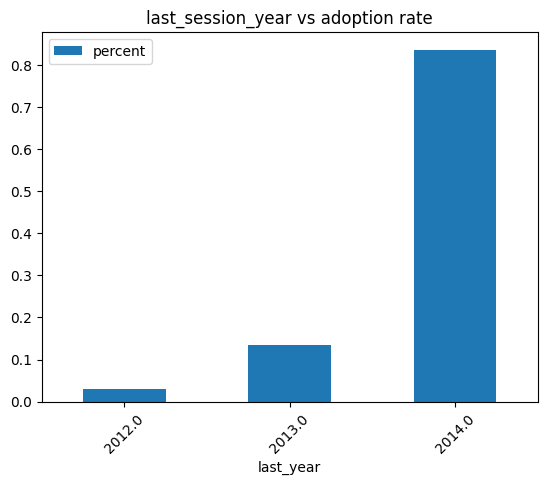

In [388]:
last_year_adopted_perc.plot(kind='bar')
plt.title('last_session_year vs adoption rate')
plt.xticks(rotation=45)
plt.show()

#### account_age vs adoption_rate

In [310]:
category=['within 3 month','3-6 month','6month-1 year','1-1.5 year','1.5-2 years']
bins = [timedelta(days=0),timedelta(days=90),timedelta(days=185), timedelta(days=365), timedelta(days=550), timedelta(days=740)]

takehome_users_engagement['account_age_group'] = pd.cut(takehome_users_engagement['account_age'], bins,labels = category)
takehome_users_engagement['account_age_group']



0        within 3 month
1         6month-1 year
2            1-1.5 year
3            1-1.5 year
4            1-1.5 year
              ...      
11995     6month-1 year
11996        1-1.5 year
11997    within 3 month
11998       1.5-2 years
11999         3-6 month
Name: account_age_group, Length: 12000, dtype: category
Categories (5, object): ['within 3 month' < '3-6 month' < '6month-1 year' < '1-1.5 year' < '1.5-2 years']

In [359]:

account_age_adopted = pd.crosstab(takehome_users_engagement.adopted, takehome_users_engagement.account_age_group).apply(lambda row: row/row.sum(), axis=0)
account_age_adopted

account_age_group,within 3 month,3-6 month,6month-1 year,1-1.5 year,1.5-2 years
adopted,,,,,
0.0,0.682063,0.625211,0.580466,0.582250,0.560875
1.0,0.052915,0.129994,0.154327,0.150019,0.163846
2.0,0.265022,0.244795,0.265207,0.267731,0.275279


In [361]:
accountage_adopted_perc = account_age_adopted.loc[1].to_frame('percent')
accountage_adopted_perc
#accountage_adopted_perc = source_adopted_perc.sort_values(by='percent')

,percent
account_age_group,
within 3 month,0.052915
3-6 month,0.129994
6month-1 year,0.154327
1-1.5 year,0.150019
1.5-2 years,0.163846


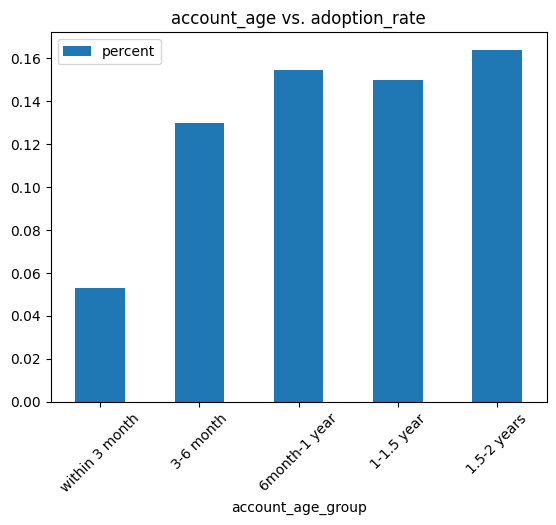

In [362]:
accountage_adopted_perc.plot(kind='bar')
plt.xticks(rotation=45)
plt.title('account_age vs. adoption_rate')
plt.show()

It shows that users who have account for 6month to 1 year adopted the most. 

#### creation source vs adoption_rate

In [318]:
takehome_users_engagement.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [364]:
source_adopted = pd.crosstab(takehome_users_engagement.adopted, takehome_users_engagement.creation_source).apply(lambda row: row/row.sum(), axis=0)
source_adopted

creation_source,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
adopted,,,,,
0.0,0.568655,0.619182,0.285647,0.770484,0.833213
1.0,0.165511,0.130230,0.076267,0.138955,0.166787
2.0,0.265834,0.250588,0.638086,0.090561,0.000000


In [365]:
source_adopted_perc = source_adopted.loc[1].to_frame('percent')
source_adopted_perc = source_adopted_perc.sort_values(by='percent')

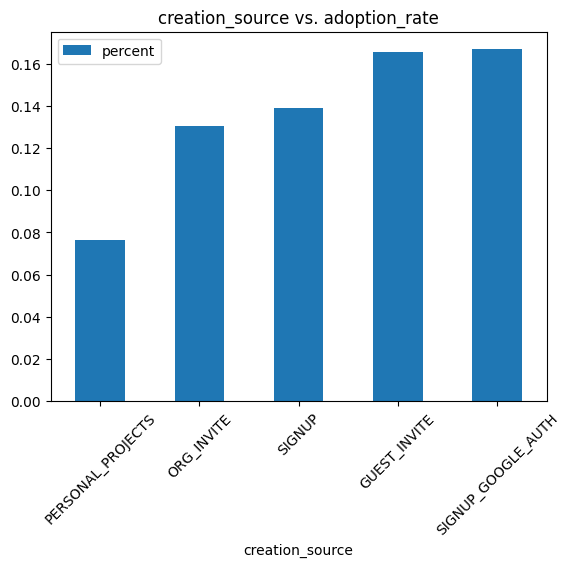

In [366]:
source_adopted_perc.plot(kind = 'bar')
plt.xticks(rotation=45)
plt.title('creation_source vs. adoption_rate')
plt.show()

In [393]:
google_adopt = takehome_users_engagement[takehome_users_engagement['creation_source'] =='SIGNUP_GOOGLE_AUTH']
google_adopt

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_day,creation_hour,creation_year,creation_month,last_day,last_hour,last_year,last_month,account_age_group
44,SIGNUP_GOOGLE_AUTH,1,0,4,NaN,0.0,Tue,21,2014,4,Wed,21.0,2014.0,4.0,within 3 month
54,SIGNUP_GOOGLE_AUTH,0,0,229,NaN,0.0,Wed,23,2012,7,Fri,23.0,2012.0,7.0,1.5-2 years
58,SIGNUP_GOOGLE_AUTH,0,0,325,NaN,0.0,Fri,3,2014,3,Sun,3.0,2014.0,6.0,3-6 month
60,SIGNUP_GOOGLE_AUTH,0,0,150,NaN,0.0,Wed,3,2014,5,Wed,3.0,2014.0,5.0,within 3 month
62,SIGNUP_GOOGLE_AUTH,0,0,203,NaN,1.0,Thu,16,2012,12,Wed,16.0,2014.0,6.0,1-1.5 year
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11982,SIGNUP_GOOGLE_AUTH,0,0,234,NaN,0.0,Tue,0,2013,7,Tue,0.0,2013.0,7.0,6month-1 year
11985,SIGNUP_GOOGLE_AUTH,0,0,111,NaN,0.0,Sun,1,2012,6,Sun,1.0,2012.0,7.0,1.5-2 years
11988,SIGNUP_GOOGLE_AUTH,1,0,22,NaN,0.0,Mon,11,2013,9,Sat,11.0,2013.0,9.0,6month-1 year
11990,SIGNUP_GOOGLE_AUTH,0,0,388,NaN,0.0,Sun,14,2014,4,Fri,14.0,2014.0,5.0,within 3 month


In [396]:
#google_adopt.groupby('creation_year')['adopted'].value_counts()

google_adopt_percent = pd.crosstab(google_adopt.adopted, google_adopt.creation_year).apply(lambda row: row/row.sum(), axis=0)
google_adopt_percent

creation_year,2012,2013,2014
adopted,,,
0.0,0.75625,0.81677,0.916865
1.0,0.24375,0.18323,0.083135


In [400]:
user_adopt = takehome_users_engagement[takehome_users_engagement['creation_source'] =='GUEST_INVITE']

user_adopt_percent = pd.crosstab(user_adopt.adopted, user_adopt.creation_year).apply(lambda row: row/row.sum(), axis=0)
user_adopt_percent

creation_year,2012,2013,2014
adopted,,,
0.0,0.514815,0.551478,0.640187
1.0,0.211111,0.188583,0.091900
2.0,0.274074,0.259939,0.267913


In [401]:
org_adopt = takehome_users_engagement[takehome_users_engagement['creation_source'] =='ORG_INVITE']

org_adopt_percent = pd.crosstab(org_adopt.adopted, org_adopt.creation_year).apply(lambda row: row/row.sum(), axis=0)
org_adopt_percent

creation_year,2012,2013,2014
adopted,,,
0.0,0.603376,0.600198,0.660700
1.0,0.150844,0.149431,0.084825
2.0,0.245781,0.250371,0.254475


In [402]:
sign_adopt = takehome_users_engagement[takehome_users_engagement['creation_source'] =='SIGNUP']

sign_adopt_percent = pd.crosstab(sign_adopt.adopted, sign_adopt.creation_year).apply(lambda row: row/row.sum(), axis=0)
sign_adopt_percent

creation_year,2012,2013,2014
adopted,,,
0.0,0.736170,0.755266,0.820968
1.0,0.159574,0.158475,0.091935
2.0,0.104255,0.086259,0.087097


In [314]:
takehome_users_engagement.invited_by_user_id.nunique()

2564

In [315]:
referral_rate = takehome_users_engagement.invited_by_user_id.nunique()/takehome_users_engagement.object_id.nunique()
referral_rate

0.21366666666666667

In [316]:
referral_count = takehome_users_engagement.invited_by_user_id.value_counts().to_frame('counts')



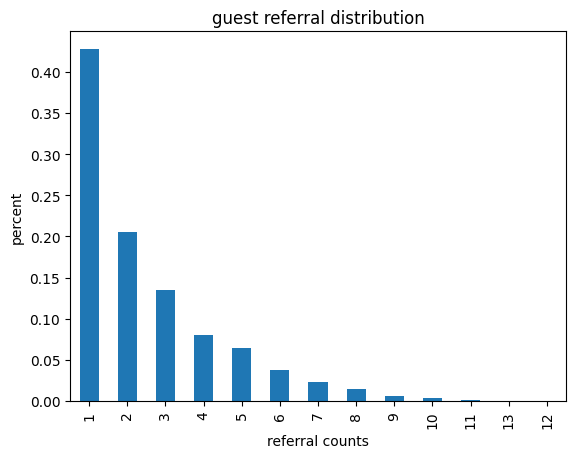

In [317]:
referral_count.counts.value_counts(normalize=True).plot(kind='bar')
plt.title('guest referral distribution')
plt.xlabel('referral counts')
plt.ylabel('percent')
plt.show()

In [380]:
creationy_refer = takehome_users_engagement.groupby('creation_year')['invited_by_user_id'].value_counts().to_frame('counts').reset_index()
creationy_refer

,creation_year,invited_by_user_id,counts
0,2012,50.0,5
1,2012,4302.0,5
2,2012,7698.0,5
3,2012,9332.0,5
4,2012,510.0,4
...,...,...,...
4164,2014,11973.0,1
4165,2014,11978.0,1
4166,2014,11981.0,1
4167,2014,11994.0,1


In [381]:
creationy_refer.groupby('creation_year')['counts'].sum()

creation_year
2012    1488
2013    3002
2014    1927
Name: counts, dtype: int64

In [ ]:
referral_creationyear = pd.crosstab(takehome_users_engagement.adopted, takehome_users_engagement.creation_year).apply(lambda row: row/row.sum(), axis=0)


In [323]:
takehome_users_engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   object_id                   12000 non-null  int64          
 1   creation_time               12000 non-null  datetime64[ns] 
 2   name                        12000 non-null  object         
 3   email                       12000 non-null  object         
 4   creation_source             12000 non-null  object         
 5   last_session_creation_time  8823 non-null   datetime64[ns] 
 6   opted_in_to_mailing_list    12000 non-null  int64          
 7   enabled_for_marketing_drip  12000 non-null  int64          
 8   org_id                      12000 non-null  int64          
 9   invited_by_user_id          6417 non-null   float64        
 10  adopted                     12000 non-null  float64        
 11  creation_day                12000 non-nul

In [324]:
takehome_users_engagement = takehome_users_engagement.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time','account_age'], axis=1)


In [325]:
takehome_users_engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   creation_source             12000 non-null  object  
 1   opted_in_to_mailing_list    12000 non-null  int64   
 2   enabled_for_marketing_drip  12000 non-null  int64   
 3   org_id                      12000 non-null  int64   
 4   invited_by_user_id          6417 non-null   float64 
 5   adopted                     12000 non-null  float64 
 6   creation_day                12000 non-null  object  
 7   creation_hour               12000 non-null  int64   
 8   creation_year               12000 non-null  int64   
 9   creation_month              12000 non-null  int64   
 10  last_day                    8823 non-null   object  
 11  last_hour                   8823 non-null   float64 
 12  last_year                   8823 non-null   float64 
 13  last_month      

### Modeling

In [326]:
#using dictionary to convert specific columns
convert_dict = {'opted_in_to_mailing_list': object,
                'enabled_for_marketing_drip': object,
                'org_id':object,
                'invited_by_user_id':object,
                'creation_hour':object,
                'creation_year': object,
                'creation_month': object,
                'last_hour':object,
                'last_year':object,
                'last_month':object,
               
            
                }
takehome_users_engagement = takehome_users_engagement.astype(convert_dict)
 



In [327]:
data = takehome_users_engagement.drop(['adopted'],axis=1)
X = pd.get_dummies(data)
X

,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_0,opted_in_to_mailing_list_1,enabled_for_marketing_drip_0,enabled_for_marketing_drip_1,org_id_0,...,last_month_8.0,last_month_9.0,last_month_10.0,last_month_11.0,last_month_12.0,account_age_group_within 3 month,account_age_group_3-6 month,account_age_group_6month-1 year,account_age_group_1-1.5 year,account_age_group_1.5-2 years
0,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,1,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
11996,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
11997,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
11998,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [328]:
y = takehome_users_engagement['adopted']
Xtrain,Xtest, ytrain, ytest = train_test_split(X,y, test_size=.3, random_state=8)

In [329]:
XGBModel =XGBClassifier(objective = 'multi:softmax',random_state = 2,scoring ='roc_auc')

XGBModel.fit(Xtrain, ytrain)
print(XGBModel.score(Xtrain, ytrain))


[22:11:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.995


In [331]:
XGBModel.score(Xtest,ytest)

0.9663888888888889

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


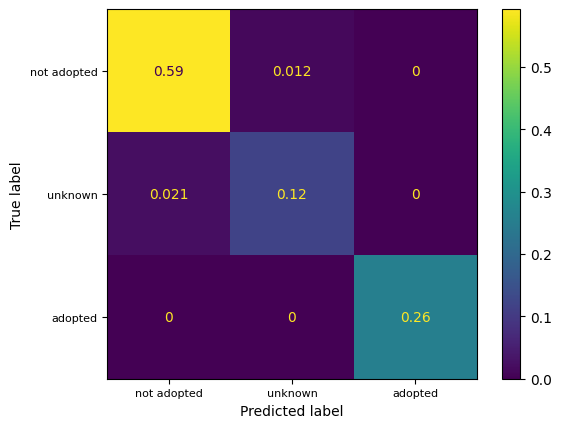

In [332]:
y_pred_test = XGBModel.predict(Xtest)

cm_rf_test = confusion_matrix(ytest, y_pred_test)
percent_cm_rf_test = cm_rf_test/cm_rf_test.sum()
_, ax = plt.subplots()
display_percent_cm_rf_test = ConfusionMatrixDisplay(confusion_matrix = percent_cm_rf_test, 
                                    display_labels = ['not adopted','unknown', 'adopted'])

ax.set_xticklabels(labels = ['not adopted','unknown', 'adopted'], fontsize = 8)
ax.set_yticklabels(labels = ['not adopted','unknown', 'adopted'], fontsize = 8)
display_percent_cm_rf_test.plot(ax = ax)

In [333]:
features=[]
for columns in X.columns:
    features.append(columns)
GBfeatures = XGBModel.feature_importances_
for i in GBfeatures:
    i.round(3)
GBfeatures = pd.DataFrame({"features":features}).join(pd.DataFrame({"weights":GBfeatures}))
GB_plot_data = GBfeatures.sort_values(by=['weights'], ascending=False).head(10)
GB_plot_data

,features,weights
3022,creation_year_2013,0.152581
3068,last_year_2013.0,0.138808
3067,last_year_2012.0,0.133831
3069,last_year_2014.0,0.117433
3023,creation_year_2014,0.111030
3021,creation_year_2012,0.030961
3028,creation_month_5,0.023341
3086,account_age_group_1.5-2 years,0.016870
3075,last_month_6.0,0.015218
3074,last_month_5.0,0.011561


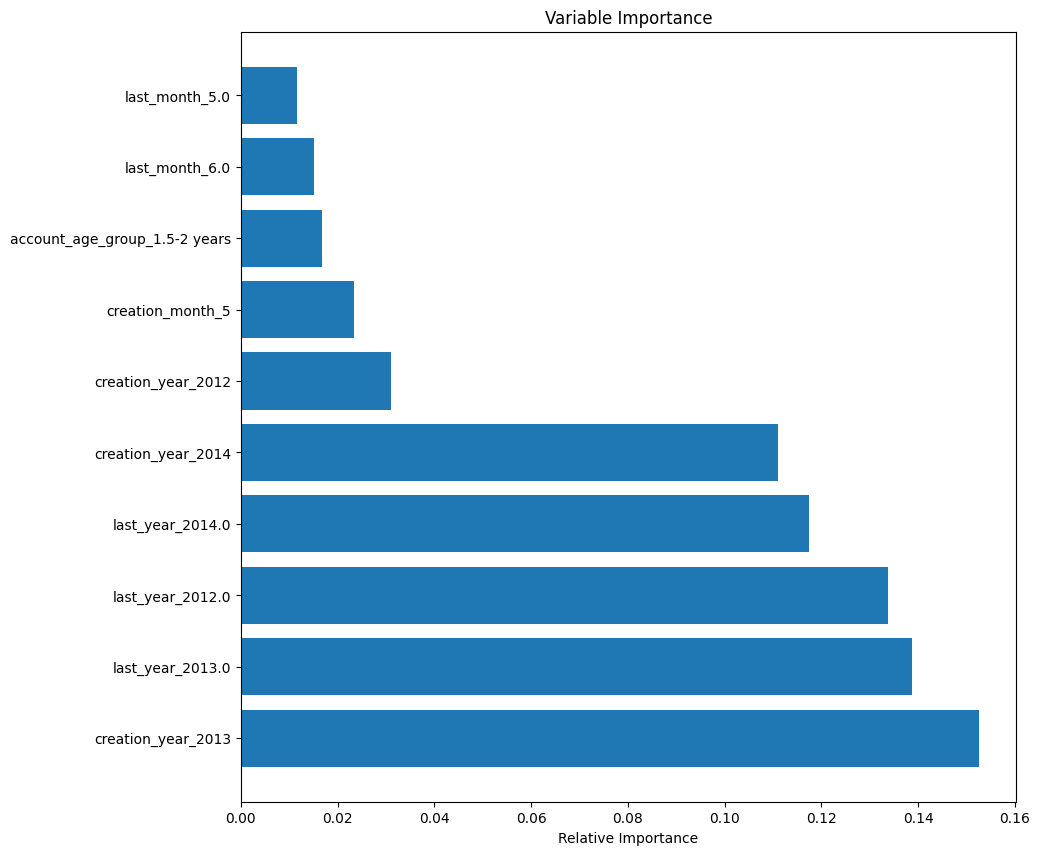

In [334]:
plt.figure(figsize=(10,10))
plt.barh(GB_plot_data['features'],GB_plot_data['weights'])
#plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()